In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 367 ms (started: 2023-07-23 13:32:53 -07:00)


A set of images of a face under different rotations and lighting conditions, used as a dataset in [Isomap](https://doi.org/10.1126/science.290.5500.2319). Unfortunately, it’s no longer available at the Stanford website, but we can rescue it from the mists of time via the [Wayback Machine](https://web.archive.org/web/20150922051706/http://isomap.stanford.edu/face_data.mat.Z).

To make things even more complicated, this file has been Z-compressed, which means you would need to uncompress this with e.g. `uncompress` (on Linux) or 7-zip (on Windows). There are some python packages that can do this for you on PyPI including [unlzw](https://pypi.org/project/unlzw/) and [unlzw3](https://pypi.org/project/unlzw3/) and [ncompress](https://pypi.org/project/ncompress/) (thank you to this [stack overflow page](https://stackoverflow.com/q/32921263/4096483)). I chose `ncompress` pretty much arbitrarily. I leaned heavily on [a gist](https://gist.github.com/jlmelville/339dfeb80c3e836e887d70a37679b244) for R to remember how to do this.

In [2]:
from io import BytesIO

import ncompress
import requests
import scipy.io

req = requests.get(
    "https://web.archive.org/web/20150922051706/http://isomap.stanford.edu:80/face_data.mat.Z",
    timeout=60,
)
faces_data = scipy.io.loadmat(
    BytesIO(ncompress.decompress(req.content)), squeeze_me=True, struct_as_record=False
)

# Equivalent with ulzw3 if ncompress doesn't work out for you:
# import unlzw3
# faces_data = scipy.io.loadmat(
#     BytesIO(unlzw3.unlzw(req.content)), squeeze_me=True, struct_as_record=False
# )

time: 812 ms (started: 2023-07-23 13:32:53 -07:00)


In [3]:
faces_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'lights', 'images', 'image_pcs', 'poses'])

time: 7.61 ms (started: 2023-07-23 13:32:54 -07:00)


In [4]:
faces_data["images"].shape

(4096, 698)

time: 8.45 ms (started: 2023-07-23 13:32:54 -07:00)


There are 698 images, each being 64 x 64 pixels in size. The data is stored by column, not row.

## View a face

In [5]:
import matplotlib.pyplot as plt


def show_face(faces, idx):
    nx = 64
    ny = nx
    plt.axis("off")
    plt.imshow(
        faces[:, idx].reshape((nx, ny)).T,
        cmap=plt.cm.gray,
        interpolation="nearest",
        vmin=0,
        vmax=1,
    )

time: 397 ms (started: 2023-07-23 13:32:54 -07:00)


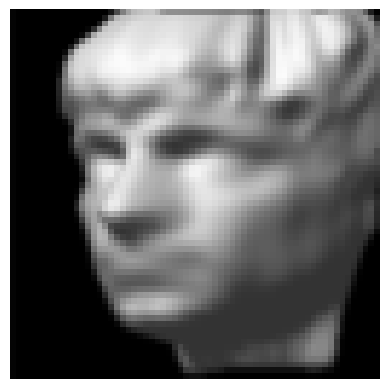

time: 87.6 ms (started: 2023-07-23 13:32:54 -07:00)


In [6]:
show_face(faces_data["images"], 0)

## Data pipeline

Data needs to be transposed to have each image in the rows:

In [7]:
data = faces_data["images"].T

time: 1.59 ms (started: 2023-07-23 13:32:54 -07:00)


The `poses` data relates to the angle of the head in each image. Using the terminology in Figure 1 of the Isomap paper, the first column encodes "left-right" pose, and the second column encodes "up-down" pose. Either could be used to color the manifold.

In [8]:
faces_data["poses"].shape

(2, 698)

time: 5.15 ms (started: 2023-07-23 13:32:54 -07:00)


Left-right examples. Increasing the value of this feature goes from left to right (i.e. increasing x-axis) in Figure 1:

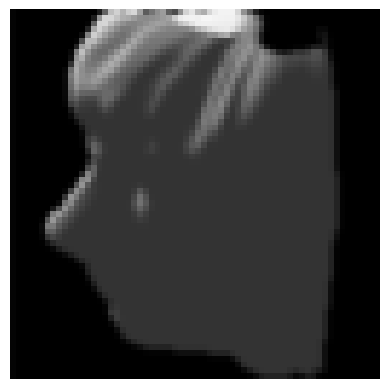

time: 53.1 ms (started: 2023-07-23 13:32:54 -07:00)


In [9]:
show_face(faces_data["images"], np.argmin(faces_data["poses"][0]))

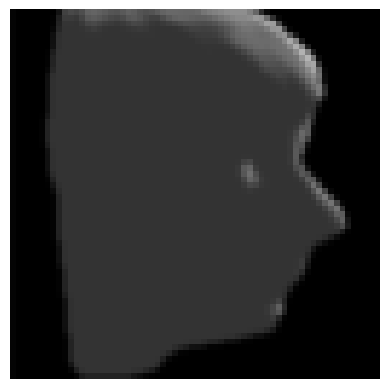

time: 63.9 ms (started: 2023-07-23 13:32:54 -07:00)


In [10]:
show_face(faces_data["images"], np.argmax(faces_data["poses"][0]))

And up-down examples. Increasing the value of this feature goes from top to bottom (i.e. decreasing y-axis) in Figure 1:

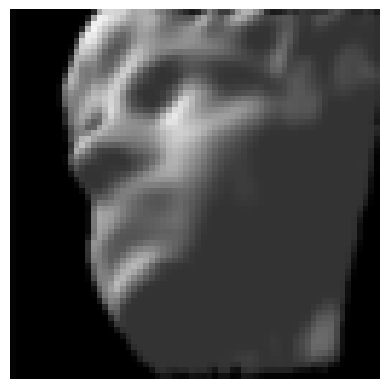

time: 59.3 ms (started: 2023-07-23 13:32:54 -07:00)


In [11]:
show_face(faces_data["images"], np.argmin(faces_data["poses"][1]))

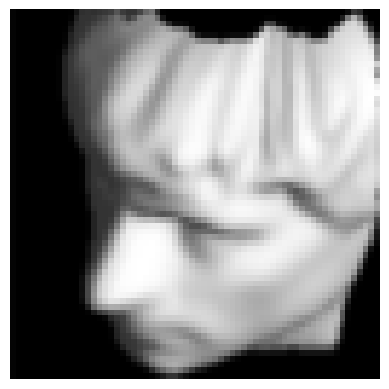

time: 57.2 ms (started: 2023-07-23 13:32:55 -07:00)


In [12]:
show_face(faces_data["images"], np.argmax(faces_data["poses"][1]))

The `lights` data is encoded in Figure 1 as a horizontal slider under the example images. Increasing values of this data encode the lighting (and the position of the slider bar in the figure) going from left to right:

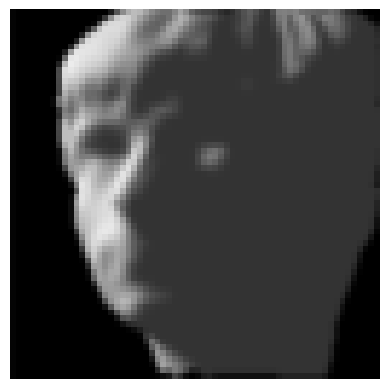

time: 57 ms (started: 2023-07-23 13:32:55 -07:00)


In [13]:
show_face(faces_data["images"], np.argmin(faces_data["lights"]))

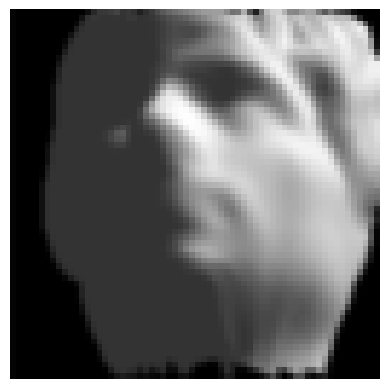

time: 58.5 ms (started: 2023-07-23 13:32:55 -07:00)


In [14]:
show_face(faces_data["images"], np.argmax(faces_data["lights"]))

As running the scikit-learn version of Isomap on this data shows that left-right layout is most clearly unfolded into 2D (see the "Isomap Plot" section below) I recommend using that as the default color of the output (with `drnb`, this means making it the last column in the `target` data).

In [15]:
target = pd.DataFrame(
    {
        "lighting-direction": faces_data["lights"],
        "up-down": faces_data["poses"][1],
        "left-right": faces_data["poses"][0],
    }
)

time: 2.73 ms (started: 2023-07-23 13:32:55 -07:00)


In [16]:
target

,lighting-direction,up-down,left-right
0,183.086157,-0.791317,-32.119184
1,199.015147,-1.963342,29.043989
2,184.105388,0.834203,-28.112839
3,139.357752,-9.700989,59.262967
4,134.411966,9.401733,-42.009602
...,...,...,...
693,199.574681,5.489509,-34.086428
694,189.803622,9.410430,-48.328393
695,226.931894,1.254550,69.475295
696,130.380497,-5.578956,24.340441


time: 13.7 ms (started: 2023-07-23 13:32:55 -07:00)


In [17]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "isofaces",
    data=data,
    target=target,
    tags=["small", "synthetic", "image", "isomap"],
    verbose=True,
)

[13:32:59] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=543304;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=701874;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#576\576]8;;\

           INFO     Initial data shape: (698, 4096)                                                  ]8;id=300156;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=4337;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#77\77]8;;\

           INFO     Keeping all columns                                                            ]8;id=307493;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=908952;file:///home/james/dev/drnb/src/drnb/preprocess.py#73\73]8;;\

           INFO     Data shape after filtering columns: (698, 4096)                                 ]8;id=180112;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=387760;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#148\148]8;;\

[13:33:00] INFO     Removing rows with NAs                                                          ]8;id=925923;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=229994;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#132\132]8;;\

           INFO     Data shape after filtering NAs: (698, 4096)                                     ]8;id=166494;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=799491;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#143\143]8;;\

           INFO     Checked for duplicates: found 0                                                 ]8;id=782446;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=747459;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#155\155]8;;\

           INFO     No scaling                                                                     ]8;id=447511;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=198285;file:///home/james/dev/drnb/src/drnb/preprocess.py#28\28]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=247905;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=809951;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#160\160]8;;\

           INFO     Writing data for isofaces                                                       ]8;id=84660;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=803203;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#228\228]8;;\

[13:33:01] INFO     Processing target with initial shape (698, 3)                                   ]8;id=721975;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=175281;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#199\199]8;;\

           INFO     Keeping all columns                                                            ]8;id=346607;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=658274;file:///home/james/dev/drnb/src/drnb/preprocess.py#73\73]8;;\

           INFO     Writing target for isofaces                                                     ]8;id=706889;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=656316;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#228\228]8;;\

[13:33:02] INFO     Calculating nearest neighbors                                                   ]8;id=946882;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=795842;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=964995;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py\loader.py]8;;\:]8;id=701863;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py#54\54]8;;\

           INFO     Successfully loaded faiss with AVX2 support.                                       ]8;id=952054;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py\loader.py]8;;\:]8;id=370195;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss-1.7.4-py3.10.egg/faiss/loader.py#56\56]8;;\

           INFO     Using 'faiss' to find nearest neighbors                                          ]8;id=481680;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=627630;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#83\83]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and params: {}           ]8;id=245580;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=318950;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#96\96]8;;\

[13:33:05] INFO     Writing numpy format to nn/isofaces.16.euclidean.exact.faiss.idx.npy            ]8;id=338128;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=885472;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.16.euclidean.exact.faiss.idx.csv              ]8;id=57925;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=408866;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.16.euclidean.exact.faiss.dist.npy           ]8;id=821100;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=496280;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.16.euclidean.exact.faiss.dist.csv             ]8;id=889901;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=366633;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.51.euclidean.exact.faiss.idx.npy            ]8;id=189377;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=531640;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.51.euclidean.exact.faiss.idx.csv              ]8;id=731038;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=716204;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

[13:33:06] INFO     Writing numpy format to nn/isofaces.51.euclidean.exact.faiss.dist.npy           ]8;id=606222;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=144578;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.51.euclidean.exact.faiss.dist.csv             ]8;id=533706;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=596598;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.151.euclidean.exact.faiss.idx.npy           ]8;id=938358;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=645921;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.151.euclidean.exact.faiss.idx.csv             ]8;id=817165;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=382908;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to nn/isofaces.151.euclidean.exact.faiss.dist.npy          ]8;id=637134;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=890944;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing csv format to nn/isofaces.151.euclidean.exact.faiss.dist.csv            ]8;id=222106;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=720798;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Calculating triplets                                                            ]8;id=585583;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=23169;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#254\254]8;;\

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[13:33:07] INFO     Writing csv format to triplets/isofaces.5.1337.idx.csv                          ]8;id=415018;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=752405;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing csv format to triplets/isofaces.5.1337.euclidean.csv                    ]8;id=437100;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=470154;file:///home/james/dev/drnb/src/drnb/io/__init__.py#283\283]8;;\

           INFO     Writing numpy format to triplets/isofaces.5.1337.idx.npy                        ]8;id=3374;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=339180;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

[13:33:08] INFO     Writing numpy format to triplets/isofaces.5.1337.euclidean.npy                  ]8;id=217119;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=264004;file:///home/james/dev/drnb/src/drnb/io/__init__.py#306\306]8;;\

           INFO     Writing pipeline result for isofaces                                            ]8;id=613489;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=839092;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#125\125]8;;\

time: 13 s (started: 2023-07-23 13:32:55 -07:00)


## Isomap Plot

It doesn't take too long to run the `sklearn` implementation of Isomap on the face data, so let's see how it works out. The Isomap paper uses 6 nearest neighbors so I'll stick with that.

In [18]:
from sklearn.manifold import Isomap

isofaces_coords = Isomap(n_neighbors=6, n_components=2).fit_transform(data)

time: 727 ms (started: 2023-07-23 13:33:08 -07:00)


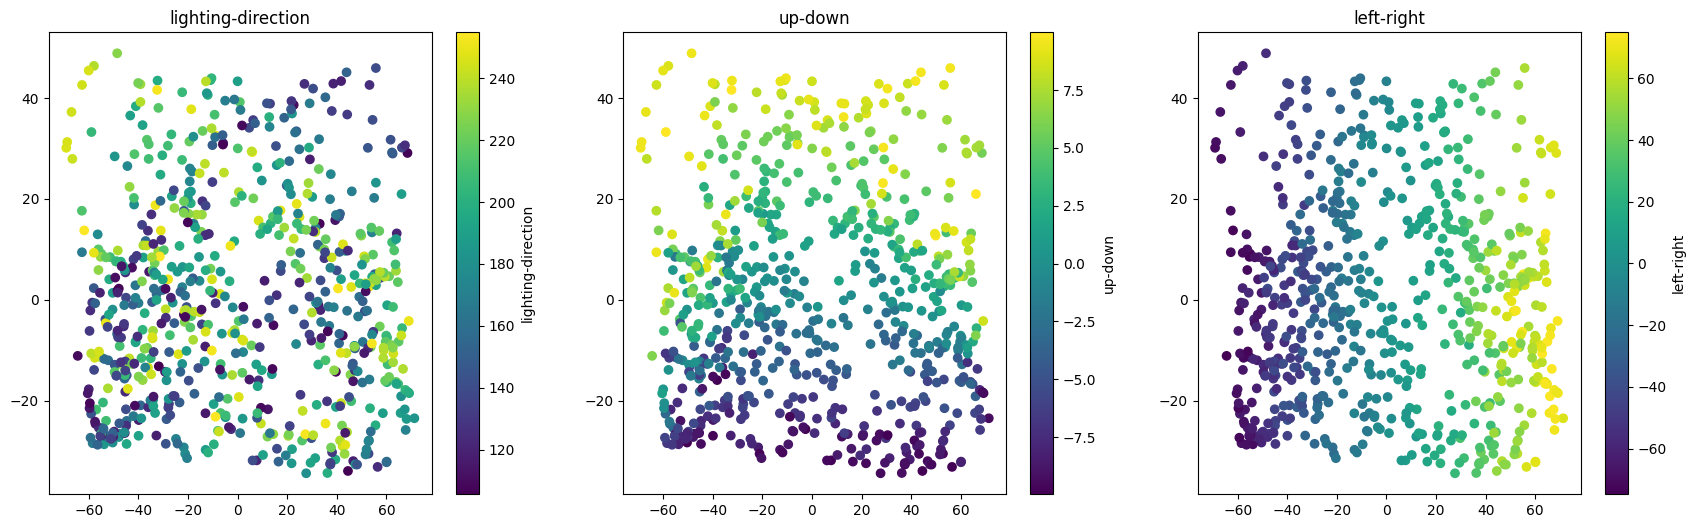

time: 963 ms (started: 2023-07-23 13:33:09 -07:00)


In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, target.shape[1], figsize=(21, 6))

for i, (name, color_scale) in enumerate(target.items()):
    sc = axs[i].scatter(
        isofaces_coords[:, 0], isofaces_coords[:, 1], c=color_scale, cmap="viridis"
    )
    fig.colorbar(sc, ax=axs[i], label=name)
    axs[i].set_title(name)

plt.show()

By staring at Figure 1 in the Isomap paper, this seems like a good, if not exact reproduction. The left-right and up-down structure seems well retained (left-right being best preserved looking at the colors). The lighting direction is not as well preserved.